# GMM

## 2.1 EM algorithm for Gaussian Mixture Model

In [2]:
import pandas as pd
import numpy as np
# load data
customer_data = pd.read_csv('SMAI-Dataset-customer-dataset/data.csv')
customer_data = customer_data.drop(["Index"],axis=1)

# normalize data
customer_data = (customer_data - customer_data.mean())/customer_data.std()
customer_data = np.array(customer_data)

In [7]:
# GMM class
class GMM:
    def __init__ (self):
        self.pi = None
        self.mu = None
        self.sigma = None
        self.k = None
        self.n = None
        self.d = None
        self.data = None
        self.gamma = None

    def fit(self,data, k, max_iter=20):
        self.k = k
        self.n = data.shape[0]
        self.d = data.shape[1]
        self.pi = np.ones(k)/k # 1Xk
        self.mu = data[np.random.choice(self.n, k, False), :] # kXd
        # print(self.mu)
        self.data = data
        self.sigma = np.array([np.identity(self.d)] * k) # kXdXd
        # i =0
        # while(i<max_iter):
        #     print(i)
        #     self.e_step()
        #     self.m_step()
        #     i+=1

        # while likelihood is not converging
        prev_ll = 0
        curr_ll = 0
        i=0
        # print(self.gaussian(self.data[0],self.mu[0],self.sigma[0]))
        while(i<max_iter):
            # print(i)
            self.e_step()
            self.m_step()
            curr_ll = self.likelihood()
            # print("likelihood",curr_ll)
            if abs(curr_ll - prev_ll) < 1e-3:
                print("converged at iteration",i, "with likelihood",curr_ll)
                break
            prev_ll = curr_ll
            i+=1
        return self.mu, self.sigma, self.pi, self.gamma

    def e_step(self):
        self.gamma = np.zeros((self.n, self.k))
        # print("mu",self.mu)
        # print("sigma",self.sigma)
        # print("pi",self.pi)

        for i in range(self.n):
            sum = 0
            for j in range(self.k):
                self.gamma[i][j] = self.pi[j] * self.gaussian(self.data[i],self.mu[j],self.sigma[j])
                if self.gamma[i][j] == 0: # to avoid log(0)
                    self.gamma[i][j] = 1e-200
                sum += self.gamma[i][j]
            # print(type(self.gamma[i][j]))
            for j in range(self.k):
                self.gamma[i][j] = self.gamma[i][j] / sum

        # print("gamma",self.gamma)
        # print()


    def m_step(self):
        self.sigma = np.array([np.identity(self.d) * 1e-10] * self.k) # kXdXd # to avoid singular matrix
        for j in range(self.k):
            Nk = np.sum(self.gamma[:, j])
            Nk += 1e-250

            # pi
            self.pi[j] = Nk/self.n

            # sigma
            for i in range(self.n):
                curr = self.data[i] - self.mu[j]
                # curr = curr[:, np.newaxis]
                curr = curr.reshape(self.d,1)
                currT = curr.T
                self.sigma[j] += self.gamma[i][j] * (curr @ currT)
            self.sigma[j] /= Nk

            # mu
            self.mu[j] = np.zeros(self.d)
            # for i in range(self.n):
            #     self.mu[j] += self.gamma[i][j] * self.data[i]
            # self.mu[j] /= Nk
            self.mu[j] = np.sum(self.gamma[:, j].reshape(self.n,1) * self.data, axis=0) / Nk



    def gaussian(self, x, mu, sigma):
        d = len(mu)  # Dimension of the data

        # Compute the normalization term
        norm_term = 1.0 / ((2 * np.pi) ** (d / 2) * np.sqrt(np.linalg.det(sigma)))

        # Compute the exponent term
        exponent = -0.5 * np.dot(np.dot((x - mu).T, np.linalg.inv(sigma)), (x - mu))

        # Compute the PDF
        pdf = norm_term * np.exp(exponent)
        return pdf
    
    def likelihood(self):
        ll = 0
        for i in range(self.n):
            s = 0
            for j in range(self.k):
                s += self.pi[j] * self.gaussian(self.data[i], self.mu[j], self.sigma[j])
            ll += np.log(s)
        return ll


In [8]:
gmm = GMM()
gama = np.sum(gmm.fit(customer_data,2,30)[3])
print(gama)
# some dummy data for checking correctness - asked chatGPT for dummy bivariate distribution
'''
np.random.seed(0)
mean1 = np.array([2, 3])
cov1 = np.array([[1, 0.5], [0.5, 1]])
mean2 = np.array([-2, -1])
cov2 = np.array([[1, -0.8], [-0.8, 1]])
data1 = np.random.multivariate_normal(mean1, cov1, 500)
data2 = np.random.multivariate_normal(mean2, cov2, 500)
data = np.vstack((data1, data2))
gmm = GMM()
print(gmm.fit(data,2)[0])
'''



0.0016083125866532416
converged at iteration 10 with likelihood 1008.4639804493447
2000.0


'\nnp.random.seed(0)\nmean1 = np.array([2, 3])\ncov1 = np.array([[1, 0.5], [0.5, 1]])\nmean2 = np.array([-2, -1])\ncov2 = np.array([[1, -0.8], [-0.8, 1]])\ndata1 = np.random.multivariate_normal(mean1, cov1, 500)\ndata2 = np.random.multivariate_normal(mean2, cov2, 500)\ndata = np.vstack((data1, data2))\ngmm = GMM()\nprint(gmm.fit(data,2)[0])\n'

## 2.2 - optimal number of clusters

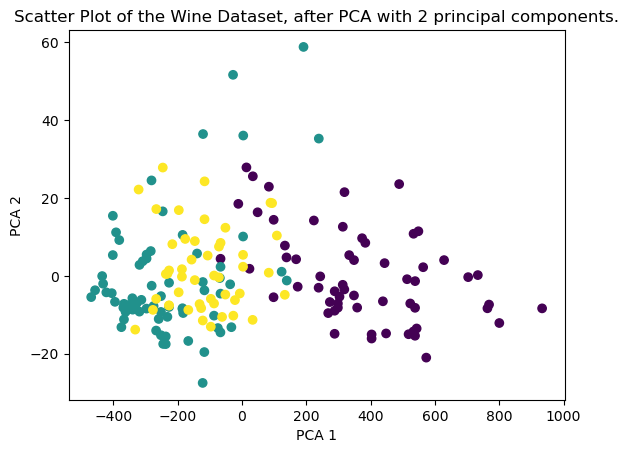

In [4]:
import sklearn.datasets as skd
import numpy as np
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

# load data

wine_data = skd.load_wine()

# Scatter Plot of the Wine Dataset, after PCA with 2 principal components.
pca = PCA(n_components=2)
wine_data_pca = pca.fit_transform(wine_data.data)
plt.scatter(wine_data_pca[:, 0], wine_data_pca[:, 1], c=wine_data.target)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Scatter Plot of the Wine Dataset, after PCA with 2 principal components.')
plt.show()

converged at iteration 2 with likelihood -1986.4799545129006
7833.480403546458
7753.932580177256
7744.180631874828
best k 4


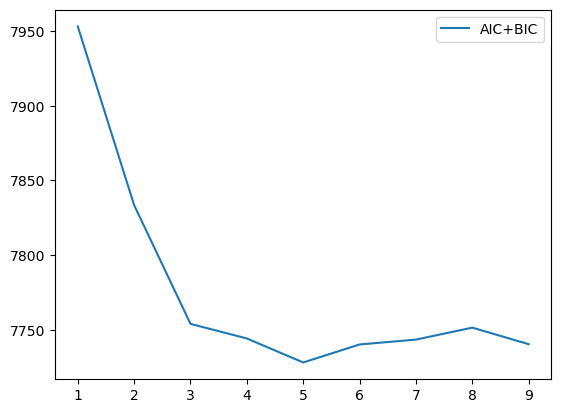

In [5]:
# use BIC and AIC to find the elbow point
best_k = 1
threshold = 70
aics = []
bics = []
aic_bis = []
for k in range(1, 10):
    gmm = GMM()
    mu, sigma, pi, gamma = gmm.fit(wine_data_pca, k, 20)
    aic = 2 * k - 2 * gmm.likelihood()
    bic = k * np.log(wine_data.data.shape[0]) - 2 * gmm.likelihood()
    aics.append(aic)
    bics.append(bic)
    aic_bis.append(aic + bic)
    # if aic_bis[-1] > max_diff_aic_and_bic:
    #     max_diff_aic_and_bic = aic_bis[-1]
    #     best_k = k

for i in range(1, 10):
    print(aic_bis[i])
    if aic_bis[i-1] - aic_bis[i] < threshold:
        best_k = i + 1
        break
print("best k", best_k)

# plt.plot(range(1, 10), aics, label='AIC')
# plt.plot(range(1, 10), bics, label='BIC')
plt.plot(range(1, 10), aic_bis, label='AIC+BIC')
plt.legend()


/home/yatharth-gupta/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


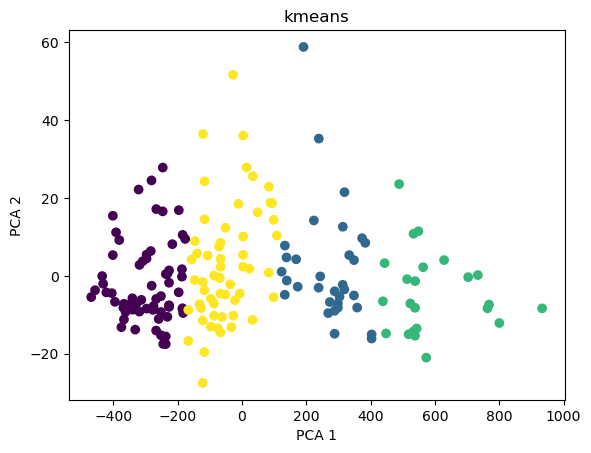

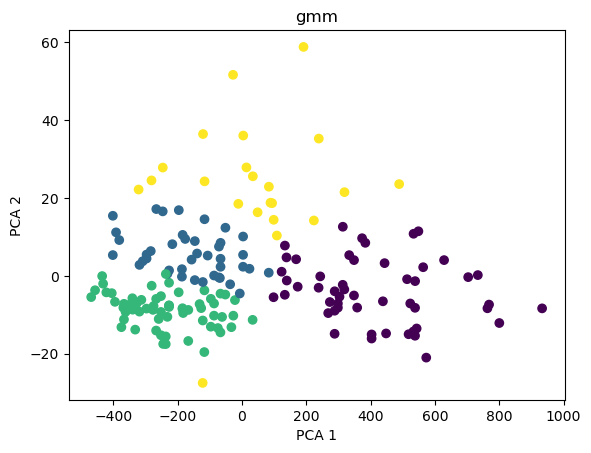

In [6]:
# import kmeans
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=best_k, random_state=0).fit(wine_data_pca)

# Scatter Plot of the Wine Dataset, after PCA with 2 principal components.
plt.scatter(wine_data_pca[:, 0], wine_data_pca[:, 1], c=kmeans.labels_)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('kmeans')
plt.show()

# scatter plot of the Wine Dataset, after PCA with 2 principal components, using gmm 
gmm = GMM()
mu, sigma, pi, gamma = gmm.fit(wine_data_pca, best_k, 20)
plt.scatter(wine_data_pca[:, 0], wine_data_pca[:, 1], c=np.argmax(gamma, axis=1))
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('gmm')
plt.show()


### Observations and analysis
### 1. The optimal number of clusters is 3.
### 2. gmm is better than kmeans in this case.
### 3. The reason is that the data is generated from 3 Gaussian distributions.
### 4. The data is not linearly separable, so kmeans is not good at it. 


In [7]:
# silhouette scores for kmeans and gmm
from sklearn.metrics import silhouette_score
print("silhouette score for kmeans", silhouette_score(wine_data_pca, kmeans.labels_))
print("silhouette score for gmm", silhouette_score(wine_data_pca, np.argmax(gamma, axis=1)))

# find the accuracy of kmeans and gmm
from sklearn.metrics import accuracy_score
print("accuracy score for kmeans", accuracy_score(wine_data.target, kmeans.labels_))
print("accuracy score for gmm", accuracy_score(wine_data.target, np.argmax(gamma, axis=1)))



silhouette score for kmeans 0.5633930017441459
silhouette score for gmm 0.11284660117831587
accuracy score for kmeans 0.02247191011235955
accuracy score for gmm 0.47191011235955055
